In [2]:
import numpy as np
import pandas as pd

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 9.5 MB/s eta 0:00:00


In [40]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


In [9]:
train_df = pd.read_csv('train.csv')

In [10]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,M,1.6125,1.2250,0.3875,37.322117,15.039410,8.249704,9.511257,11.0
1,1,I,1.4250,1.1125,0.3875,24.791638,8.873394,5.060386,8.221355,12.0
2,2,M,1.4000,1.1625,0.3625,26.223288,11.013781,4.904464,7.796112,11.0
3,3,F,1.6125,1.2625,0.4750,35.819593,15.053584,8.391452,9.355335,10.0
4,4,F,1.4625,1.1250,0.4500,28.718044,9.142714,5.811648,9.071840,16.0


In [11]:
train_df.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.313336,1.021221,0.346552,23.281539,10.059810,5.035248,6.684707,9.950733
std,4330.271354,0.292277,0.241307,0.091748,12.756765,5.659113,2.817911,3.621076,3.213626
min,0.000000,0.175000,0.000000,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,3749.750000,1.150000,0.875000,0.287500,13.196692,5.669900,2.806601,3.827183,8.000000
50%,7499.500000,1.375000,1.075000,0.362500,23.728531,9.893975,4.918638,6.803880,10.000000
75%,11249.250000,1.537500,1.200000,0.412500,32.162508,13.976304,7.002326,9.071840,11.000000
max,14999.000000,2.037500,1.625000,0.625000,80.249489,42.184056,18.413000,25.429502,29.000000


In [16]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,15000,F,1.6625,1.3125,0.4625,38.782116,14.231449,7.002326,11.906790
1,15001,M,1.4875,1.1500,0.4250,27.187171,12.870673,5.145434,8.363103
2,15002,F,1.3000,0.9750,0.2750,15.436303,7.810287,3.260193,4.252425
3,15003,M,1.2125,0.9625,0.3375,16.456885,6.747181,3.898056,4.535920
4,15004,I,1.3125,1.0375,0.3750,18.597272,6.874754,2.948348,6.803880


In [13]:
train_df.shape

(15000, 10)

In [17]:
test_df.shape

(10000, 9)

In [18]:
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [19]:
test_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

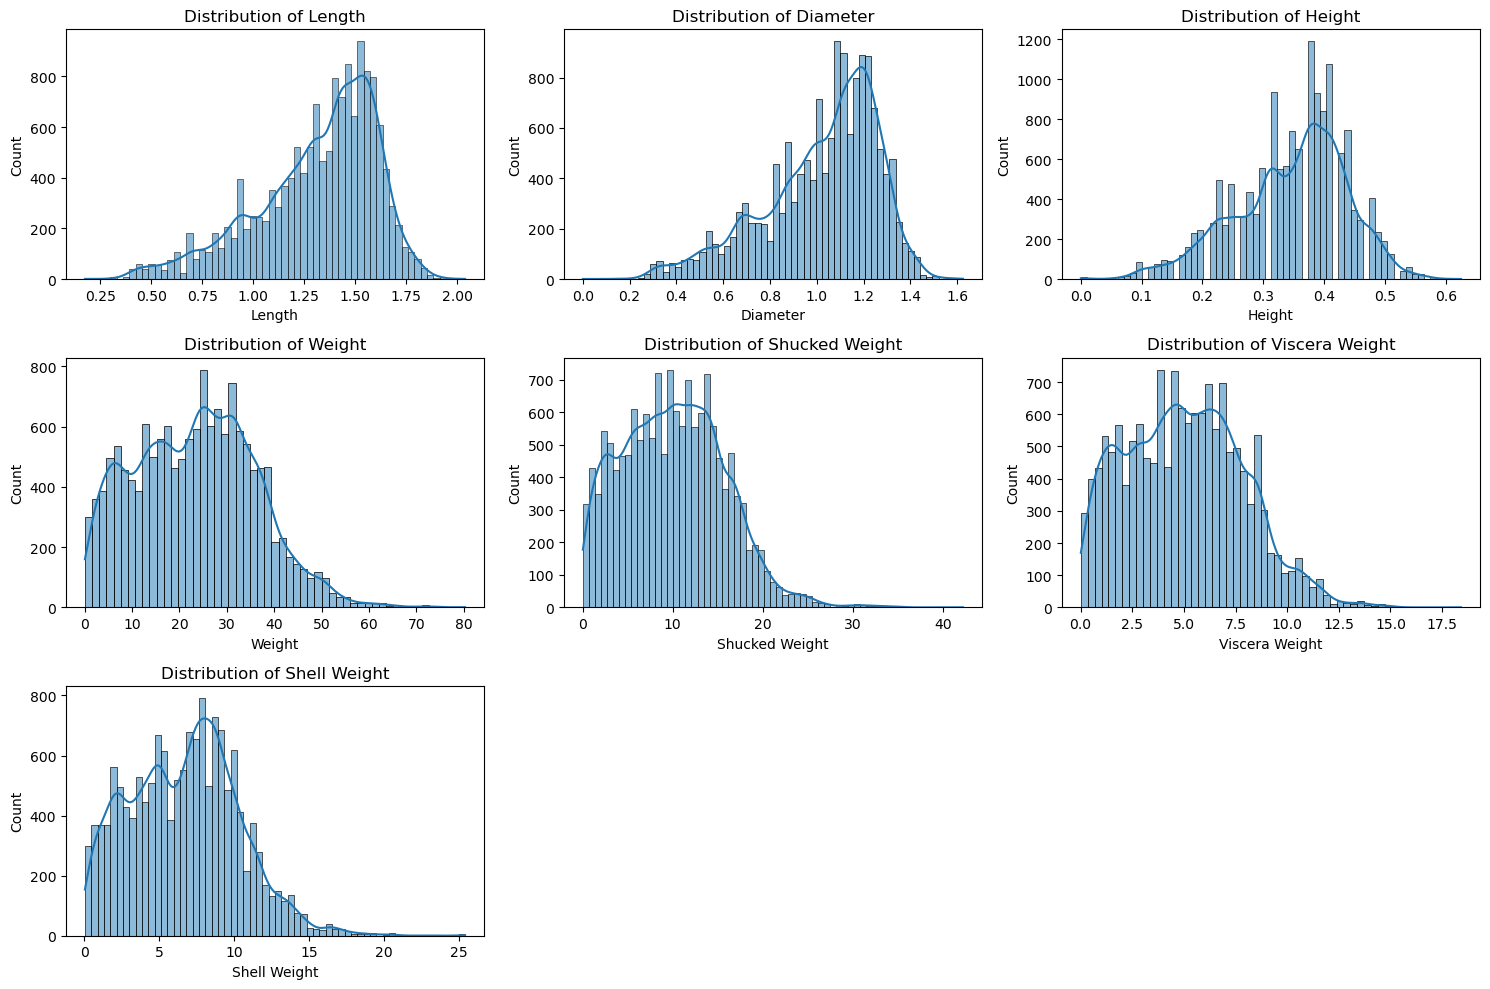

In [22]:
# feature distribution for numerical features

plt.figure(figsize=(15,10))
for i, col in enumerate(['Length','Diameter','Height','Weight','Shucked Weight',
                         'Viscera Weight', 'Shell Weight']):
    plt.subplot(3,3,i+1)
    sns.histplot(train_df[col], kde = True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.savefig('feature_distribution.png')

In [25]:
train_df.drop(['id','Sex'], axis=1).corr()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Length,1.000000,0.992442,0.937447,0.936756,0.912455,0.920994,0.917137,0.630566
Diameter,0.992442,1.000000,0.939990,0.938782,0.911764,0.921971,0.922164,0.637283
Height,0.937447,0.939990,1.000000,0.917411,0.873765,0.901545,0.918735,0.671641
Weight,0.936756,0.938782,0.917411,1.000000,0.968849,0.974320,0.965327,0.621027
Shucked Weight,0.912455,0.911764,0.873765,0.968849,1.000000,0.945805,0.904397,0.511507
Viscera Weight,0.920994,0.921971,0.901545,0.974320,0.945805,1.000000,0.936190,0.592298
Shell Weight,0.917137,0.922164,0.918735,0.965327,0.904397,0.936190,1.000000,0.689722
Age,0.630566,0.637283,0.671641,0.621027,0.511507,0.592298,0.689722,1.000000


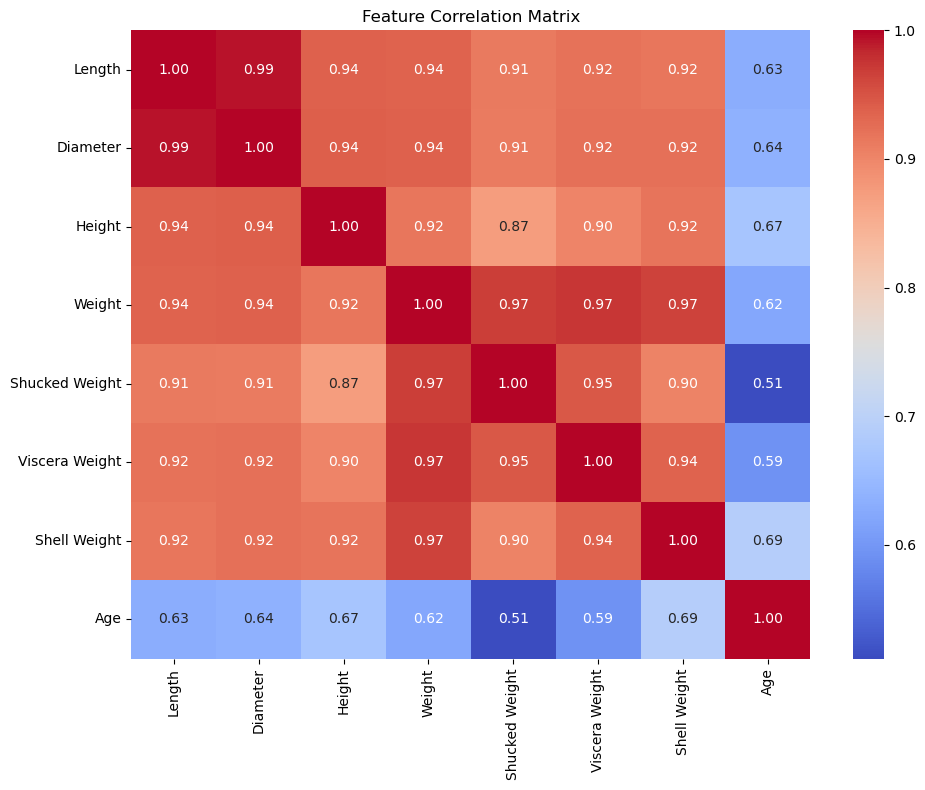

In [30]:
# correlation matrix

plt.figure(figsize=(10,8))
corr_matrix = train_df.drop(['id','Sex'],axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

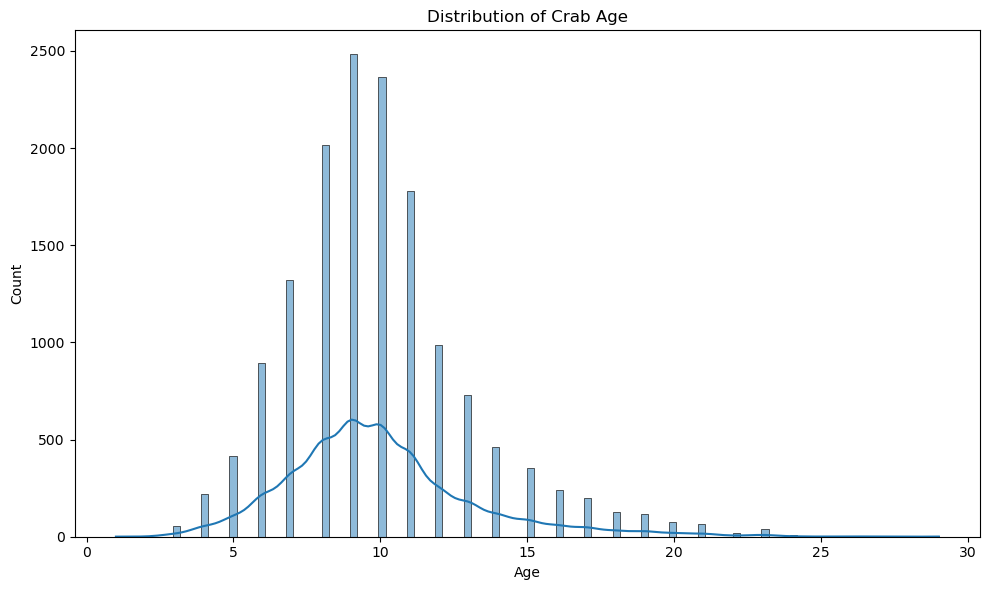

In [34]:
# target distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'], kde=True)
plt.title('Distribution of Crab Age')
plt.tight_layout()
plt.savefig('age_distribution.png')

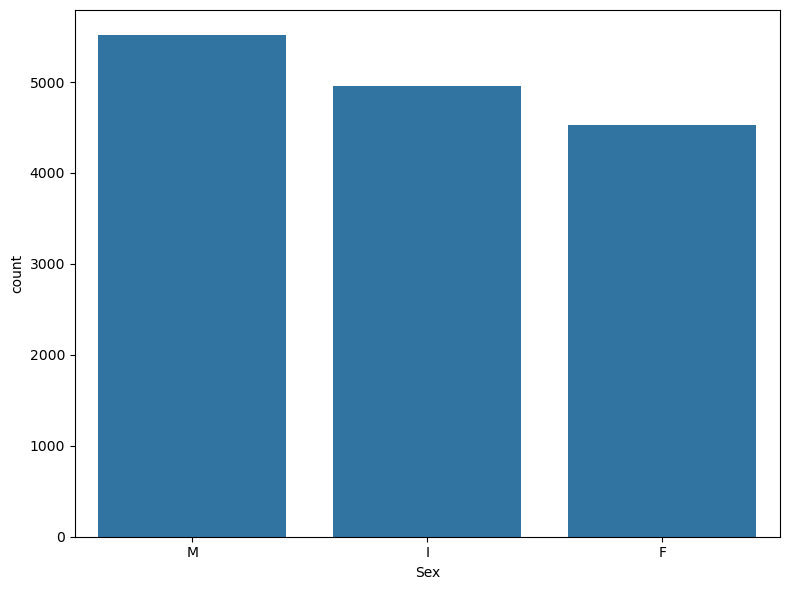

In [35]:
# sex distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Sex', data=train_df)
plt.tight_layout()
plt.savefig('sex_distribution.png')

# Feature Engineering

In [41]:
#encoding Sex column
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])

## New features

In [42]:
# volume approx. = length*diameter*height
train_df['Volume'] = train_df['Length']*train_df['Diameter']*train_df['Height']
test_df['Volume'] = test_df['Length']*test_df['Diameter']*test_df['Height']

#density approx. = weight/volume
train_df['Density'] = train_df['Weight']/train_df['Volume']
test_df['Density'] = test_df['Weight']/test_df['Volume']

# Meatweight (total wt. - shell wt.)
train_df['Meat_Weight'] = train_df['Weight'] - train_df['Shell Weight']
test_df['Meat_Weight'] = test_df['Weight'] - test_df['Shell Weight']

#shell ratio
train_df['Shell_ratio'] = train_df['Shell Weight']/train_df['Weight']
test_df['Shell_ratio'] = test_df['Shell Weight']/test_df['Weight']

#shucked ratio
train_df['Shucked_ratio'] = train_df['Shucked Weight']/train_df['Weight']
test_df['Shucked_ratio'] = test_df['Shucked Weight']/test_df['Weight']

#viscera wt. ratio
train_df['Viscera_ratio'] = train_df['Viscera Weight']/train_df['Weight']
test_df['Viscera_ratio'] = test_df['Viscera Weight']/test_df['Weight']

In [44]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Volume,Density,Meat_Weight,Shell_ratio,Shucked_ratio,Viscera_ratio
0,0,2,1.6125,1.2250,0.3875,37.322117,15.039410,8.249704,9.511257,11.0,0.765434,48.759444,27.810859,0.254842,0.402962,0.221041
1,1,1,1.4250,1.1125,0.3875,24.791638,8.873394,5.060386,8.221355,12.0,0.614309,40.356977,16.570283,0.331618,0.357919,0.204117
2,2,2,1.4000,1.1625,0.3625,26.223288,11.013781,4.904464,7.796112,11.0,0.589969,44.448604,18.427175,0.297297,0.420000,0.187027
3,3,0,1.6125,1.2625,0.4750,35.819593,15.053584,8.391452,9.355335,10.0,0.966996,37.042128,26.464258,0.261179,0.420261,0.234270
4,4,0,1.4625,1.1250,0.4500,28.718044,9.142714,5.811648,9.071840,16.0,0.740391,38.787692,19.646203,0.315893,0.318361,0.202369


In [46]:
for df in [train_df, test_df]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)

In [47]:
#target_split----scale----train_val_split

X = train_df.drop(columns=['id', 'Age'])
y = train_df['Age']
X_test = test_df.drop(columns=['id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled, X_val_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)



In [48]:
 models = {
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42),
        'LightGBM': lgb.LGBMRegressor(random_state=42),
        'ElasticNet': ElasticNet(random_state=42)
    }

In [52]:
cv_results = {}
    
for name, model in models.items():
        # Use scaled features for ElasticNet
        if name == 'ElasticNet':
            scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
        else:
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
        
        cv_results[name] = -scores.mean()
        print(f"{name} CV RMSE: {-scores.mean():.4f}")
    
# Find best model from CV
best_model_name = min(cv_results, key=cv_results.get)
print(f"\nBest model based on CV: {best_model_name} with RMSE: {cv_results[best_model_name]:.4f}")

# Hyperparameter tuning for best model
print(f"\nFine-tuning {best_model_name}...")

if best_model_name == 'Gradient Boosting':
    model = GradientBoostingRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    }

elif best_model_name == 'Random Forest':
    model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
elif best_model_name == 'XGBoost':
    model = xgb.XGBRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

elif best_model_name == 'LightGBM':
    model = lgb.LGBMRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70],
        'subsample': [0.8, 0.9, 1.0]
    }

elif best_model_name == 'ElasticNet':
    model = ElasticNet(random_state=42)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

Gradient Boosting CV RMSE: 1.9639
Random Forest CV RMSE: 2.0164
XGBoost CV RMSE: 2.0696
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 14
[LightGBM] [Info] Start training from score 9.967583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 14
[LightGBM] [Info] Start training from score 9.944917
[Lig

In [53]:
 # Run a more limited grid search for faster execution
grid_search = GridSearchCV(
    model, 
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

if best_model_name == 'ElasticNet':
    grid_search.fit(X_scaled, y)
else:
    grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [54]:
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")


Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9}
Best CV RMSE: 1.9573


In [56]:
# Get the top 3 models
top_models = sorted(cv_results.items(), key=lambda x: x[1])[:3]
print(f"Using top models: {[m[0] for m in top_models]}")

# Train each model with its best parameters or default if not tuned
trained_models = []

# Gradient Boosting
if 'Gradient Boosting' in [m[0] for m in top_models]:
    if best_model_name == 'Gradient Boosting':
        gb_model = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
    else:
        gb_model = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=4)
    gb_model.fit(X, y)
    trained_models.append(('Gradient Boosting', gb_model, False))  # False means no scaling needed

# Random Forest
if 'Random Forest' in [m[0] for m in top_models]:
    if best_model_name == 'Random Forest':
        rf_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    else:
        rf_model = RandomForestRegressor(random_state=42, n_estimators=200)
    rf_model.fit(X, y)
    trained_models.append(('Random Forest', rf_model, False))

# XGBoost
if 'XGBoost' in [m[0] for m in top_models]:
    if best_model_name == 'XGBoost':
        xgb_model = xgb.XGBRegressor(**grid_search.best_params_, random_state=42)
    else:
        xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=200)
    xgb_model.fit(X, y)
    trained_models.append(('XGBoost', xgb_model, False))

# LightGBM
if 'LightGBM' in [m[0] for m in top_models]:
    if best_model_name == 'LightGBM':
        lgb_model = lgb.LGBMRegressor(**grid_search.best_params_, random_state=42)
    else:
        lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=200)
    lgb_model.fit(X, y)
    trained_models.append(('LightGBM', lgb_model, False))

# ElasticNet
if 'ElasticNet' in [m[0] for m in top_models]:
    if best_model_name == 'ElasticNet':
        en_model = ElasticNet(**grid_search.best_params_, random_state=42)
    else:
        en_model = ElasticNet(random_state=42, alpha=0.01, l1_ratio=0.5)
    en_model.fit(X_scaled, y)
    trained_models.append(('ElasticNet', en_model, True))  # True means scaling needed

Using top models: ['Gradient Boosting', 'LightGBM', 'Random Forest']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2830
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 14
[LightGBM] [Info] Start training from score 9.950733


In [57]:
# Make predictions with each model
ensemble_predictions = []

print("\nMaking predictions with ensemble...")
for name, model, needs_scaling in trained_models:
    if needs_scaling:
        preds = model.predict(X_test_scaled)
    else:
        preds = model.predict(X_test)
    ensemble_predictions.append(preds)
    print(f"Added predictions from {name}")

# Average the predictions
final_predictions = np.mean(ensemble_predictions, axis=0)

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'Age': final_predictions
})

# Ensure predictions are within reasonable bounds
# Check min and max age in training set
min_age = y.min()
max_age = y.max()

# Clip predictions to be within the range of observed ages
submission['Age'] = submission['Age'].clip(min_age, max_age)

# Save submission file
submission.to_csv('crab_age_predictions.csv', index=False)
print("\nSuccessfully created submission file: crab_age_predictions.csv")


Making predictions with ensemble...
Added predictions from Gradient Boosting
Added predictions from Random Forest
Added predictions from LightGBM

Successfully created submission file: crab_age_predictions.csv



Top feature importances:
Shell Weight: 0.5963
Shucked_ratio: 0.2086
Height: 0.0963
Shell_ratio: 0.0237
Sex: 0.0190
Volume: 0.0155
Viscera_ratio: 0.0149
Viscera Weight: 0.0053
Length: 0.0051
Shucked Weight: 0.0044


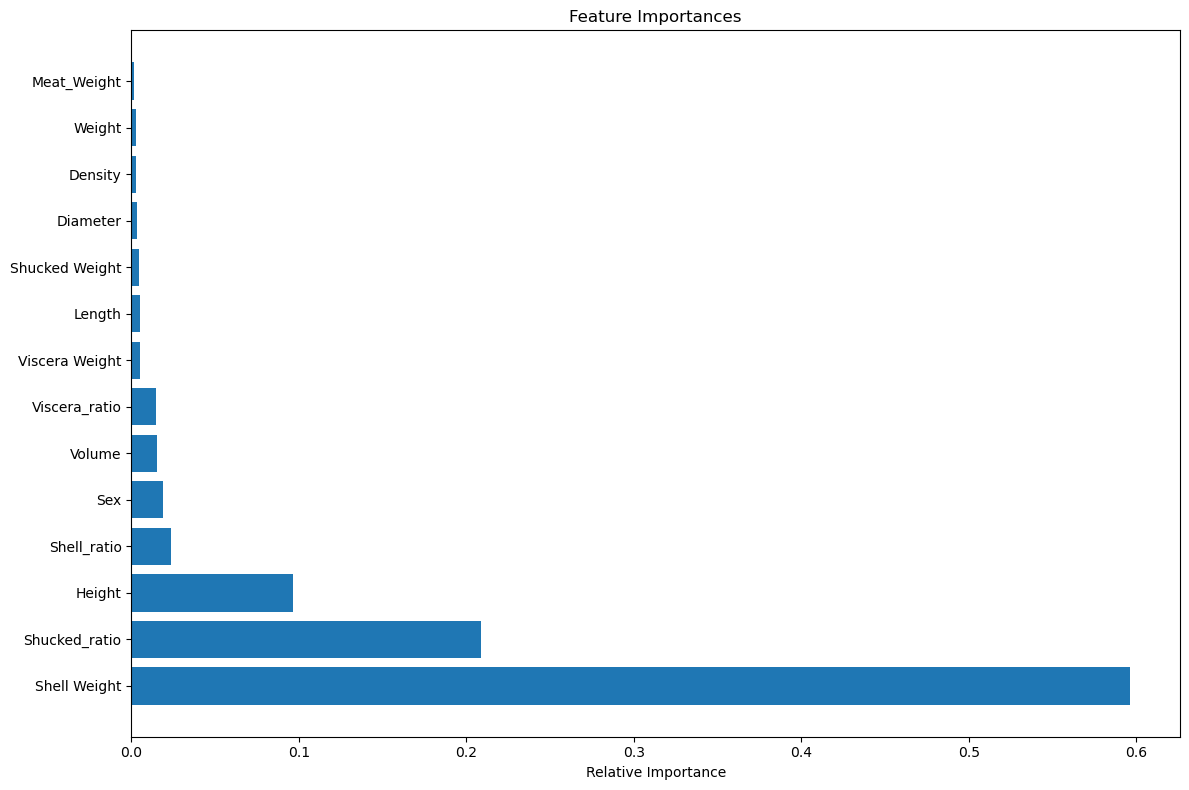

In [60]:
# Feature importance from the best model
if best_model_name in ['Gradient Boosting', 'Random Forest', 'XGBoost', 'LightGBM']:
    print("\nTop feature importances:")
    best_model = grid_search.best_estimator_
    importance = best_model.feature_importances_
    feature_names = X.columns
    
    # Sort features by importance
    indices = np.argsort(importance)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importance[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    # Print top 10 features
    for i in range(min(10, len(feature_names))):
        print(f"{feature_names[indices[i]]}: {importance[indices[i]]:.4f}")